<a href="https://colab.research.google.com/github/asad-mahmood/Tensorflow-Learning-and-Specialization/blob/main/Course%204%20-%20Sequences%2C%20Time%20Series%20and%20Prediction/Week%20-%204%20Sunspots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-03-05 05:30:55--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 142.250.73.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0s      

2021-03-05 05:30:55 (143 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



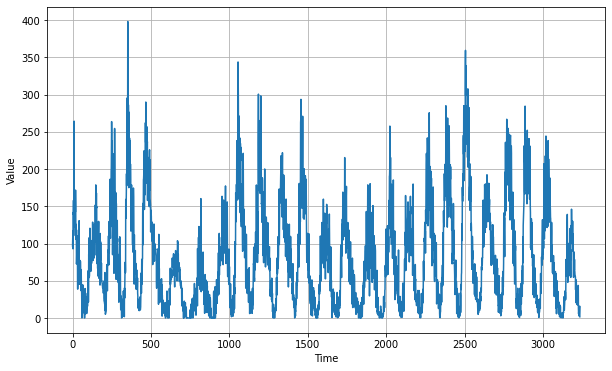

In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

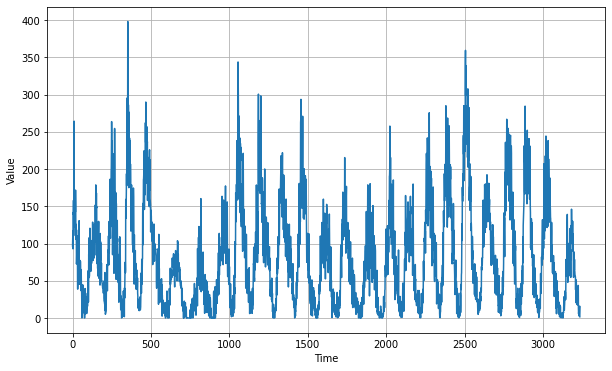

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 34s 32ms/step - loss: 77.0308 - mae: 77.5277
Epoch 2/100
12/12 [==============================] - 0s 30ms/step - loss: 75.8295 - mae: 76.3264
Epoch 3/100
12/12 [==============================] - 0s 27ms/step - loss: 73.8409 - mae: 74.3386
Epoch 4/100
12/12 [==============================] - 0s 28ms/step - loss: 70.0323 - mae: 70.5301
Epoch 5/100
12/12 [==============================] - 0s 28ms/step - loss: 66.1753 - mae: 66.6732
Epoch 6/100
12/12 [==============================] - 0s 31ms/step - loss: 62.9767 - mae: 63.4740
Epoch 7/100
12/12 [==============================] - 0s 29ms/step - loss: 59.8143 - mae: 60.3113
Epoch 8/100
12/12 [==============================] - 0s 31ms/step - loss: 56.0738 - mae: 56.5700
Epoch 9/100
12/12 [==============================] - 0s 29ms/step - loss: 52.7464 - mae: 53.2425
Epoch 10/100
12/12 [====

(1e-08, 0.0001, 0.0, 60.0)

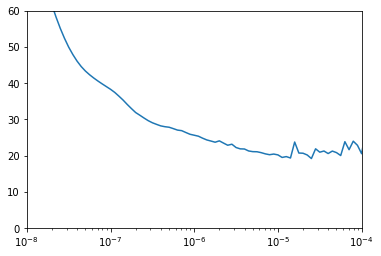

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 3s 30ms/step - loss: 47.7134 - mae: 48.2106
Epoch 2/500
30/30 [==============================] - 1s 15ms/step - loss: 26.8674 - mae: 27.3623
Epoch 3/500
30/30 [==============================] - 1s 15ms/step - loss: 22.9798 - mae: 23.4743
Epoch 4/500
30/30 [==============================] - 1s 17ms/step - loss: 20.2815 - mae: 20.7747
Epoch 5/500
30/30 [==============================] - 1s 16ms/step - loss: 19.2273 - mae: 19.7197
Epoch 6/500
30/30 [==============================] - 1s 16ms/step - loss: 18.9923 - mae: 19.4845
Epoch 7/500
30/30 [==============================] - 1s 17ms/step - loss: 18.4470 - mae: 18.9390
Epoch 8/500
30/30 [==============================] - 1s 16ms/step - loss: 18.0240 - mae: 18.5151
Epoch 9/500
30/30 [==============================] - 1s 17ms/step - loss: 18.1027 - mae: 18.5941
Epoch 10/500
30/30 [==============================] - 1s 16ms/step - loss: 19.4977 - mae: 19.9899
Epoch 11/500
30/30 [=========

In [12]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

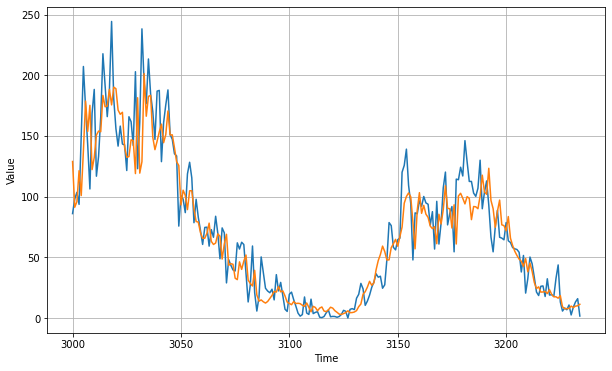

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.107962

<Figure size 432x288 with 0 Axes>

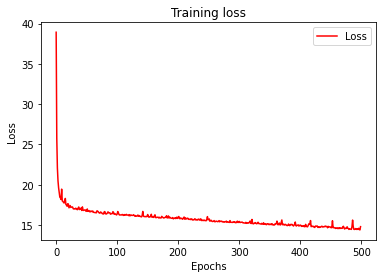

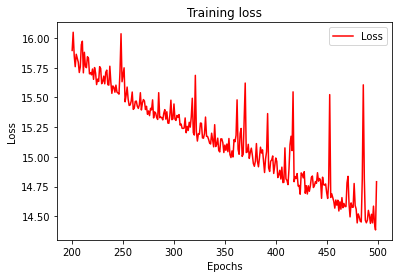

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [16]:
print(rnn_forecast)

[128.92743    91.211395   95.82897   121.34075   100.86971   137.69331
 178.74203   153.71461   175.209     122.23215   132.25732   150.71703
 154.00262   153.46117   183.39317   174.03848   174.60971   188.37175
 175.56314   190.166     188.92203   171.25156   167.8265    169.45224
 140.63335   132.43086   132.9256    146.81003   146.04602   118.9728
 181.43575   119.34304   128.77812   201.33496   166.2342    182.56573
 183.41002   148.94354   138.67992   145.66536   153.4111    159.70483
 144.43088   151.09618   170.54164   150.79387   150.88933   140.30728
 128.7415    125.610115   93.10916   105.25847   101.009834   89.28322
 104.771935  104.8805     89.58594    79.48519    78.97008    70.299904
  65.59985    65.732086   69.807396   78.14027    63.11153    60.5608
  61.757244   69.28268    67.36716    48.53105    61.00453    68.94987
  43.387104   44.74976    44.25659    32.764236   31.58111    46.226593
  40.031506   46.848434   51.871277   31.17896    28.431208   26.352438
  39.